In [742]:
from synthtiger import components, layers
from elements.textbox import TextBox
from elements.content import TextReader
from layouts import GridStack

from PIL import Image, ImageDraw
import numpy as np
import os, yaml, re
os.chdir('/workspace')

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

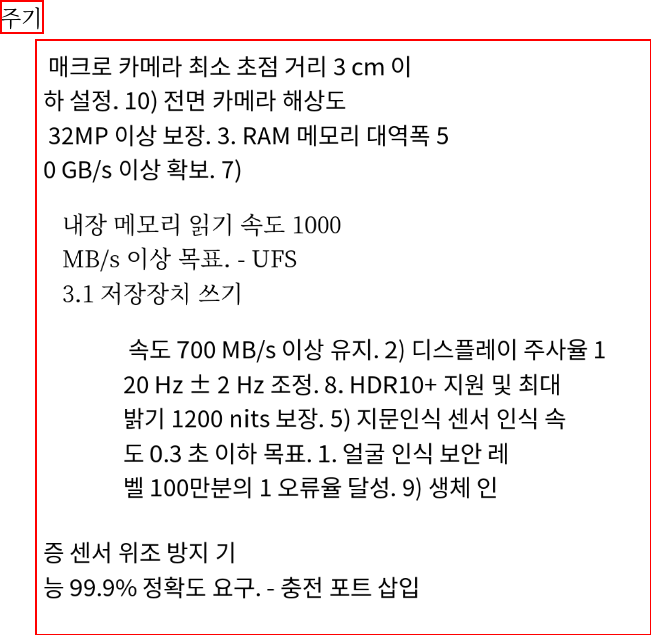

In [894]:
# config setting
layout = GridStack(config.get('document').get('content').get('layout'))
margin = config.get("document").get("content").get("margin", [0, 0.1])
base_font = components.BaseFont(**config.get("document").get("content").get("font"))
reader = TextReader(**config.get('document').get('content').get('text'))
textbox = TextBox(config.get("document").get("content").get("textbox"))

landscape = config.get("landscape", 0.5)
short_size = config.get("short_size", [720, 1024])
aspect_ratio = config.get("aspect_ratio", [1, 2])

landscape = np.random.rand() < landscape
short_size = np.random.randint(short_size[0], short_size[1] + 1)
aspect_ratio = np.random.uniform(aspect_ratio[0], aspect_ratio[1])
long_size = int(short_size * aspect_ratio)
size = (long_size, short_size) if landscape else (short_size, long_size)

# test
width, height = size
layout_left = width * 0.1
layout_top = height * 0.1
layout_width = max(width - layout_left * 2, 0)
layout_height = max(height - layout_top * 2, 0)
layout_bbox = [layout_left, layout_top, layout_width, layout_height]

text_layers, texts = [], []
layouts = layout.generate(layout_bbox)
reader.move(np.random.randint(len(reader)))

# 주기 Layer
note_font = base_font.sample()
note_font = {**note_font, "size": int(layouts[0][0][0][-1]*0.66)} # text_scale 반영

note_layer = layers.TextLayer("주기", **note_font)
note_layer.left = layout_left * np.random.uniform(0.4, 0.5)
note_layer.top = layout_top * np.random.uniform(0.4, 0.5)
text_layers.append(note_layer)
texts.append("주기")

for layout in layouts:
    font = base_font.sample()

    for bbox, align in layout:
        x, y, w, h = bbox
        text_layer, text = textbox.generate((w, h), reader, font)
        reader.prev()

        if text_layer is None:
            continue

        text_layer.center = (x + w / 2, y + h / 2)
        if align == "left":
            text_layer.left = x
        if align == "right":
            text_layer.right = x + w
        text_layers.append(text_layer)
        texts.append(text)
        
paper_layer = layers.RectLayer(size, (255, 255, 255, 255))

document_group = layers.Group([*text_layers, paper_layer])
document_space = np.clip(size - document_group.size, 0, None)
document_group.left = np.random.randint(document_space[0] + 1)
document_group.top = np.random.randint(document_space[1] + 1)

bg_layer = layers.RectLayer(size, (255, 255, 255, 255)) # 배경 레이어 추후 변경?
layer = layers.Group([*document_group.layers, bg_layer]).merge() # group을 layer로 변환

# layouts bounding box
def extract_x_coordinate(item):
    coordinate, _ = item
    x, _, _, _ = coordinate
    return x
x_left = min([extract_x_coordinate(sublist[0]) for sublist in layouts])
x_right = max([extract_x_coordinate(sublist[0]) for sublist in layouts])

_, y_top, w, h = layouts[0][0][0]
_, y_bottom, _, _ = layouts[-1][-1][0]

layouts_bbox = map(int, [x_left*0.9, y_top*0.9, (x_right+w)*1.05, (y_bottom+h)*1.05])

# 주기 bounding box
x,y,w,h = map(int, text_layers[0].bbox)

## Image Drawing
image = layer.output(bbox=[0, 0, *size])
image = Image.fromarray(image[..., :3].astype(np.uint8))
# image crop
crop_img = image.crop([x, y], layouts_bbox[2:])

# label
label = "".join(texts)
label = label.strip()
label = re.sub(r"\s+", " ", label)

# crop된 이미지의 roi
roi = {}
roi["note"] = np.array([0, 0, w, h], dtype=int)
# 전체 Layout에 대한 Bounding Box
roi["layouts"] = layouts_bbox - [x,y,x,y]

data = {
    "image": np.array(crop_img),
    "label": label,
    "roi": roi,
}

# Bounding Box display
draw = ImageDraw.Draw(crop_img)
draw.rectangle(list(roi["note"]), outline="red", width=2)
draw.rectangle(list(roi["layouts"]), outline="red", width=2)

crop_img.show()

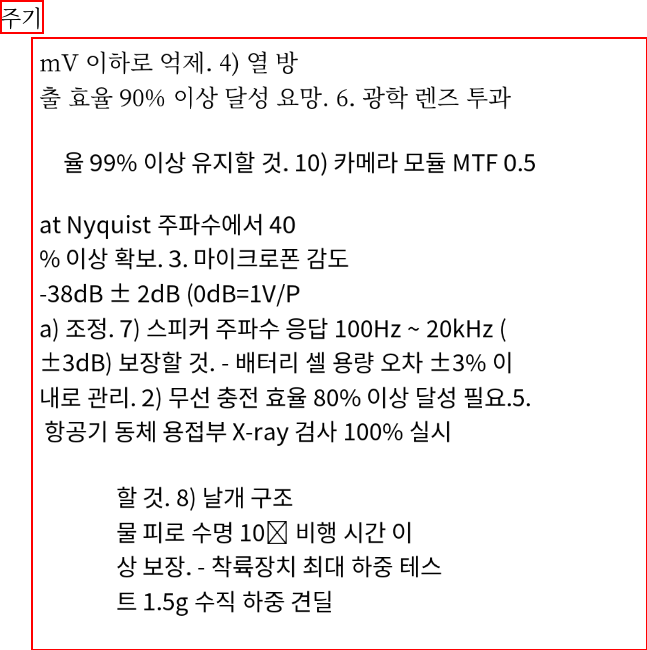

In [851]:
temp = np.array(crop_img)
Image.fromarray(temp[..., :3].astype(np.uint8)).show()

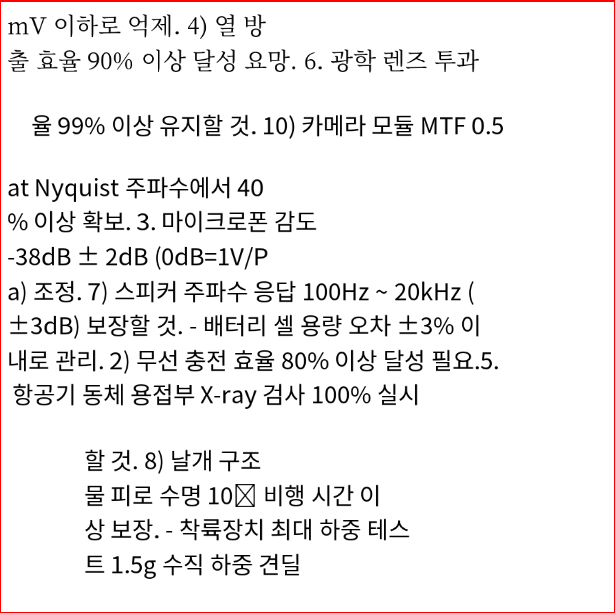

In [835]:
img.crop(layouts_bbox)

In [748]:
def convert_to_yolo_format(bbox, image_width, image_height):
    x, y, w, h = bbox
    
    x_center = (x + w/2) / image_width
    y_center = (y + h/2) / image_height
    width = w / image_width
    height = h / image_height
    
    return [x_center, y_center, width, height]
convert_to_yolo_format(note_layer.bbox, image.width, image.height)

AttributeError: 'numpy.ndarray' object has no attribute 'width'

[0.0774652295642429,
 0.06701989438798693,
 0.059722216924031575,
 0.04583333863152398]